## Source:
1.  http://nlp.seas.harvard.edu/annotated-transformer/#background
2.  https://github.com/harvardnlp/annotated-transformer/blob/master/AnnotatedTransformer.ipynb

In [7]:
import os
from os.path import exists
import math
import copy
import time

import torch
import torch.nn as nn
from torch.nn.functional import log_softmax, pad
from torch.optim.lr_scheduler import LambdaLR
from torch.utils.data import DataLoader
from torch.utils.data.distributed import DistributedSampler
import torch.distributed as dist
import torch.multiprocessing as mp
from torch.nn.parallel import DistributedDataParallel as DDP
from torchtext.data.functional import to_map_style_dataset
from torchtext.vocab import build_vocab_from_iterator
import torchtext.datasets as datasets

import pandas as pd
import altair
import spacy
import GPUtil
import warnings
import matplotlib.pyplot as plt
import numpy as np

warnings.filterwarnings("ignore")
RUN_EXAMPLES = True

In [2]:
# Convenience helper functions

def is_interactive_notebook():
    return __name__ == "__main__"

def show_example(fn, args=[]):
    if __name__ == "__main__" and RUN_EXAMPLES:
        return fn(*args)
    
def execute_example(fn, args=[]):
    if __name__ == "__main__" and RUN_EXAMPLES:
        fn(*args)
        
class DummyOptimizer(torch.optim.Optimizer):
    def __init__(self):
        self.param_groups = [{"lr": 0}]
        None
    
    def step(self):
        None
        
    def zero_grad(self, set_to_none=False):
        None

class DummyScheduler:
    def step(self):
        None

## Model Utils

In [3]:
def clones(module, N):
    """
    Return the N identical layers be it encoder or decoder
    """
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

class LayerNorm(nn.Module):
    """
    compute the layer normalization. Pytorch function can be used here for simplicity.
    """
    def __init__(self, features, eps= 1e-6):
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.eps = eps
        
    def forward(self, x):
        mean = x.mean(-1, keepdim= True)
        std = x.std(-1, keepdim= True)
        return self.a_2 * (x-mean)/ (std + self.eps) + self.b_2
    
class SubLayerConnection(nn.Module):
    """
    Code for residual connections and layer norms
    
    """
    
    def __init__(self, size, prob):
        super(SubLayerConnection, self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(prob)
        
    def forward(self, x, sub_layer):
        return x + self.dropout(sub_layer(self.norm(x)))
    
def attention(query, key, value, mask=None, dropout= None):
    d_q = query.size(-1)
    unnorm_attention_weights = torch.matmul(query, key.transpose(-2, -1))/ math.sqrt(d_q)
    if mask is not None:
        scores = scores.masked_fill(mask == 0, 1e-9)
    attention_weights = scores.softmax(dim= -1)
    if dropout is not None:
        attention_weights = dropout(attention_weights)
    return torch.matmul(attention_weights, value), attention_weights

class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model, p_dropout=0.1):
        super(MultiHeadedAttention, self).__init__()
        self.d_k = d_model//h
        self.h = h
        self.linears = clones(nn.Linear(d_model, d_model), 4)
        self.attn = None
        self.dropout = nn.Dropout(p=p_dropout)
    
    def forward(self, q, k, v, mask=None):
        if mask is not None:
            mask = mask.unsqueeze(1)
        
        nbatches = q.size[0]
        
        # Apply linear layers
        q, k, v = [
            lin(x).view(n_batches, -1, self.h, self.d_k).transpose(1, 2)
            for lin, x in zip(self.linears, (q, k, v))
        ]
        
        # Apply attention
        x, self.attn = attention(q, k, v, mask = mask, dropout=self.dropout)
        
        # Concatenate
        x = (x.transpose(1,2).contiguous().view(nbatches, -1, self.h*self.d_k))
        del q
        del k
        del v
        return self.linears[-1](x)

## Overall encoder-decoder architecture of Transformer

In [4]:
# Encoder-Decoder
class EncoderDecoder(nn.Module):
    def __init__(self, encoder, decoder, src_embed, tgt_embed, generator):
        super(EncoderDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.tgt_embed = tgt_embed
        self.generator = generator
        
    def forward(self, src, tgt, src_mask, tgt_mask):
        return self.decode(self.encode(src, src_mask), src_mask, tgt, tgt_mask)

    def encode(self, src, src_mask):
        return self.encoder(self.src_embed(src), src_mask)

    def decode(self, memory, src_mask, tgt, tgt_mask):
        return self.decoder(self.tgt_embed(tgt), memory, src_mask, tgt_mask)
    

class Generator(nn.Module):
    """
    MLP and Softmax for the decoder output in transformer architecture
    """
    def __init__(self, d_model, vocab):
        super(Generator, self).__init__()
        self.proj = nn.Linear(d_model, vocab)
        
    def forward(self, x):
        return log_softmax(self.proj(x), dim= -1)

## Encoder

In [5]:
class Encoder(nn.Module):
    """
    Encoder definition with N encoderlayers.
    Encoder layer is defined as a seperate module.
    """
    
    def __init__(self, layer, N):
        super(Encoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
        
    def forward(self, x, mask):
        for layer in self.layers:
            x = layer(x, mask)
        x = self.norm(x)
        return x

class EncoderLayer(nn.Module):
    """
    Definition of each Encoder layer i.e., Multi Head Attention and Feed Forward layer.
    """
    
    def __init__(self, size, self_attn, feed_forward, p_dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SubLayerConnection(size, p_dropout), 2)
        self.size = size
        
    def forward(self, x, mask):
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask))
        x = self.sublayer[1](x, self.feed_forward)
        return x
    

## Deocder

In [6]:
class Decoder(nn.Module):
    """
    Decoder definition with N decoder layers
    Decoeder layer is defined as a seperate module
    """
    
    def __init__(self, layer, N):
        super(Decoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
        
    def forward(self, x, encoder_op, src_mask, tgt_mask):
        for layer in self.layers:
            x = layer(x, encoder_op, src_mask, tgt_mask)
        x = self.norm(x)
        return x
        
class DecoderLayer(nn.Module):
    """
    Definition of each Decoder Layer i.e., two Multi Head Attentions (with and without mask) and Feed Forward layer
    """
    def __init__(self, size, self_attn, feed_forward, src_attn, p_dropout):
        super(DecoderLayer, self).__init__()
        self.size = size
        self.self_attn = self_attn
        self.src_attn = src_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SubLayerConnection(size, p_dropout), 3)
    
    def forward(self, x, encoder_op, src_mask, tgt_mask):
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, tgt_mask))
        x = self.sublayer[1](x, lambda x: self.src_attn(x, encoder_op, encoder_op, src_mask))
        x = self.sublayer[2](x, lambda x: self.feed_forward)
        return x

## Position wise feed forward

In [7]:
class PositionwiseFeedForward(nn.Module):
    """
    Feed forward layers in encoder and decoder, applied to each position seperately.
    """
    def __init__(self, d_model, d_ff, p_dropout = 0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(p_dropout)
        
    def forward(self, x):
        return self.w_2(self.dropout(self.w_1(x).relu()))

## Embeddings and Pos encoding

In [8]:
class Embeddings(nn.Module):
    def __init__(self, d_model, vocab):
        super(Embeddings, self).__init__()
        self.embed = nn.Embedding(vocab, d_model)
        self.d_model = d_model
        
    def forward(self, x):
        return self.embed(x) * math.sqrt(self.d_model)

In [9]:
class PositionEncoding(nn.Module):
    def __init__(self, d_model, p_dropout, max_len=5000):
        super(PositionEncoding, self).__init__()
        self.dropout = nn.Dropout(p_dropout)
        
        pos_embed = torch.zeros(max_len, d_model)
        pos = torch.arange(0, max_len).unsqueeze(1)
        divider = torch.exp(torch.arange(0, d_model, 2) * (-(math.log(10000.)/d_model)))
        
        pos_embed[:, 0::2] = torch.sin(pos * divider)        
        pos_embed[:, 1::2] = torch.cos(pos * divider)
        pos_embed = pos_embed.squeeze(0)
        self.register_buffer("pos_embed", pos_embed)
        
    def forward(self, x):
        x += self.pe[:,: x.size(1)].requires_grad_(False)
        x = self.dropout(x)
        return x

In [10]:
def Transformer(src_vocab, tgt_vocab, N=6, d_model=512, h=8, p_dropout=0.1, d_ff=2048):
    c = copy.deepcopy
    attn = MultiHeadedAttention(h, d_model)
    pwff = PositionwiseFeedForward(d_model, d_ff, p_dropout)
    pos_embed = PositionEncoding(d_model, p_dropout)
    model = EncoderDecoder(
        Encoder(EncoderLayer(d_model, c(attn), c(pwff), p_dropout), N),
        Decoder(DecoderLayer(d_model, c(attn), c(attn), c(pwff), p_dropout), N),
        nn.Sequential(Embeddings(d_model, src_vocab), c(pos_embed)),
        nn.Sequential(Embeddings(d_model, tgt_vocab), c(pos_embed)),
        Generator(d_model, tgt_vocab),
    )
    
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)
    return model

In [11]:
def inference_test():
    test_model = Transformer(11, 11, 2)
    test_model.eval()
    src = torch.LongTensor([[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]])
    src_mask = torch.ones(1, 1, 10)

    memory = test_model.encode(src, src_mask)
    ys = torch.zeros(1, 1).type_as(src)

    for i in range(9):
        out = test_model.decode(
            memory, src_mask, ys, subsequent_mask(ys.size(1)).type_as(src.data)
        )
        prob = test_model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.data[0]
        ys = torch.cat(
            [ys, torch.empty(1, 1).type_as(src.data).fill_(next_word)], dim=1
        )

    print("Example Untrained Model Prediction:", ys)


def run_tests():
    for _ in range(10):
        inference_test()


show_example(run_tests)

In [8]:
def subsequent_mask(size):
    """
    Mask the subsequent positions for the decoder. So it has no glimpse of future
    """
    attn_shape = (1, size, size)
    sub_mask = np.triu(np.ones(attn_shape), k=1).astype(np.uint8)
    return torch.from_numpy(sub_mask) == 0

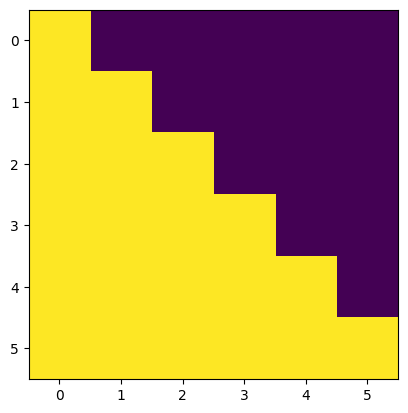

In [11]:
plt.figure()
plt.imshow(subsequent_mask(6)[0])
plt.show()

In [14]:
x = subsequent_mask(3)
print(x[0])

tensor([[ True, False, False],
        [ True,  True, False],
        [ True,  True,  True]])


## Training

In [15]:
class Batch:
    """
    The object of this class holds the src and target sentences and also constructs the masks.
    """
    def __init__(self, src, tgt = None, pad = 0):
        self.src = src
        self.src_mask = (src != pad).unsqueeze(-2)
        if tgt is not None:
            self.tgt = tgt[:, :-1]
            self.tgt_y = tgt[:, 1:]
            self.tgt_mask = self.mask_std_mask(self.tgt, pad)
            self.n_tokens = (self.tgt_y != pad).data.sum()
    
    @staticmethod
    def make_std_mask(tgt, pad):
        tgt_mask = (tgt != pad).unsqueeze(-2)
        tgt_mask = tgt_mask & Variable(subsequent_mask(tgt.size(-1)).type_as(tgt_mask.data))
        return tgt_mask

In [16]:
# Training loop
def run_epoch(iterator, model, loss_fn):
    start = time.time()
    total_tokens = 0
    total_loss = 0
    tokens = 0
    for i, batch in enumerate(iterator):
        y_pred = model.forward(batch.src, batch.tgt,
                               batch.src_mask, batch.tgt_mask)
        loss = loss_fn(y_pred, batch.tgt_y, batch.n_tokens)
        total_loss += loss
        total_tokens += batch.n_tokens
        tokens += batch.n_tokens
        if i%50 == 1:
            elapsed = time.time()-start
            print("Epoch: %d, Loss: %f, Tokens pro sec: %f" %(i, loss/batch.n_tokens, tokens/elapsed))
            start = time.time()
            tokens = 0
    return total_loss/total_tokens